In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from plot_field import generate_afl_oval, plot_events
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

chains_raw =  pd.read_pickle("../data/chains_raw.pkl")
chains_processed = pd.read_pickle("../data/chains_processed.pkl")
possession_summary = pd.read_pickle("../data/possessions_processed.pkl")

In [ ]:
from collections import Counter
res = []
for index, row in possession_summary[possession_summary.finalDisposal < possession_summary.n - 1].head(1000).iterrows():
    if row.disposal == 1:
        res.append(row.disposalList[-1])
        if row.disposalList[-1] == "Goal":
            print(row.possessionId)

Counter(res)

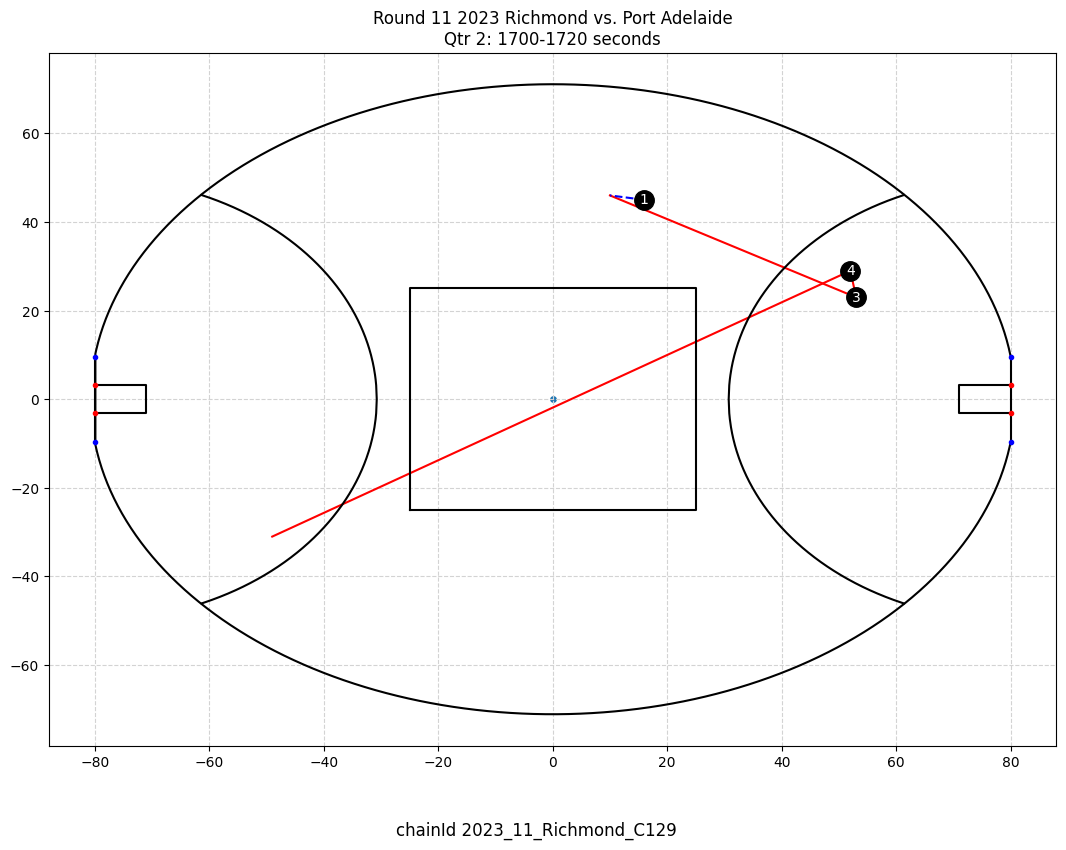

In [4]:
plot_events(possession_summary, chains_processed, id_type="chainId")

In [11]:
chains_2023.columns
# chains_2023[chains_2023.possessionId == '2023_7_Melbourne_C74_P1']
# chains_2023[chains_2023.chainId.isin(plot_df.chainId.unique())]
chains_raw[chains_raw.chainId.isin(['2023_11_Richmond_C129'])]#, '2023_11_Richmond_C130'])]

# possession_summary[possession_summary.chainId.isin(['2023_11_Richmond_C129'])]
# possession_summary[possession_summary.chainId.isin(['2023_1_GWS_Giants_C20', '2023_1_GWS_Giants_C21'])]

,season,roundNumber,homeTeam,awayTeam,homeTeamScore,awayTeamScore,date,venueName,venueWidth,venueLength,homeTeamDirectionQtr1,displayOrder,chainNumber,initialState,finalState,period,periodSeconds,playingFor,playerId,firstName,surname,position,description,disposal,shotAtGoal,behindInfo,x,y,possessionNum,chainId,possessionId
198320,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1042,129,possGain,outOfBounds,2,1700,Port Adelaide,CD_I994295,Dan,Houston,MEDIUM_DEFENDER,Contested Mark,NaN,NaN,NaN,16,45,1,2023_11_Richmond_C129,2023_11_Richmond_C129_P1
198321,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1043,129,possGain,outOfBounds,2,1710,Port Adelaide,CD_I994295,Dan,Houston,MEDIUM_DEFENDER,Kick,effective,NaN,NaN,10,46,1,2023_11_Richmond_C129,2023_11_Richmond_C129_P1
198322,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1044,129,possGain,outOfBounds,2,1710,Port Adelaide,CD_I994295,Dan,Houston,MEDIUM_DEFENDER,Kick Into F50,NaN,NaN,NaN,10,46,1,2023_11_Richmond_C129,2023_11_Richmond_C129_P1
198323,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1045,129,possGain,outOfBounds,2,1711,NaN,NaN,NaN,NaN,NaN,Kick Inside 50 Result,NaN,NaN,NaN,53,23,2,2023_11_Richmond_C129,2023_11_Richmond_C129_P2
198324,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1046,129,possGain,outOfBounds,2,1713,Richmond,CD_I1000223,Liam,Baker,MEDIUM_DEFENDER,Spoil,NaN,NaN,NaN,53,23,3,2023_11_Richmond_C129,2023_11_Richmond_C129_P3
198325,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1047,129,possGain,outOfBounds,2,1715,Port Adelaide,CD_I993979,Sam,Powell-Pepper,MEDIUM_FORWARD,Loose Ball Get,NaN,NaN,NaN,52,29,4,2023_11_Richmond_C129,2023_11_Richmond_C129_P4
198326,2023,11,Richmond,Port Adelaide,67,77,2023-05-28,MCG,141,160,left,1048,129,possGain,outOfBounds,2,1720,NaN,NaN,NaN,NaN,NaN,Out of Bounds,NaN,NaN,NaN,68,39,5,2023_11_Richmond_C129,2023_11_Richmond_C129_P5


In [29]:
chains_2023[chains_2023.possessionId.isin(chains_2023[chains_2023.description.str.contains('Mark')].sample(1).possessionId.values)][['playingFor', 'playerId', 'firstName', 'surname', 'position', 'description', 'disposal']]

,playingFor,playerId,firstName,surname,position,description,disposal
316869,Carlton,CD_I1009241,Brodie,Kemp,KEY_DEFENDER,Uncontested Mark,NaN
316870,Carlton,CD_I1009241,Brodie,Kemp,KEY_DEFENDER,Bounce,NaN
316871,Carlton,CD_I1009241,Brodie,Kemp,KEY_DEFENDER,Bounce,NaN
316872,Carlton,CD_I1009241,Brodie,Kemp,KEY_DEFENDER,Kick,ineffective


In [ ]:
t = chains_2023.copy()
t['nextPlay'] = chains_2023.groupby('possessionId').description.shift(-1)
# 
t[t.description == "Handball"].nextPlay.value_counts()

# t[(t.description == "Kick") & (t.nextPlay == "Loose Ball Get")].sample(1).possessionId


In [ ]:
chains_2023[chains_2023.possessionId == '2023_1_North_Melbourne_C48_P4']

In [ ]:
## Sanity check - visualise a possession
df = chains_2023[(chains_2023.roundNumber == 1) & (chains_2023['homeTeam'] == "Richmond") & (chains_2023.period == 1) & (chains_2023.chainNumber == 2)]
df
# plt.scatter('x', 'y', c='chainNumber', data=df)

In [ ]:
# Create pass networks - subset the possession summary and join on player names

pass_network = possession_summary[['season', 'roundNumber', 'possessionId','playingFor', 'playerId','disposalRecipient', 'finalState']].merge(player_info, on='playerId', how='inner')
pass_network = pass_network.merge(player_info, left_on='disposalRecipient', right_on='playerId', how='inner', suffixes=['_disposer','_reciever'])

# Count interations
pass_network.groupby(['playingFor']).value_counts(['full_name_disposer', 'full_name_reciever', 'finalState']).sort_values(ascending=False).head(40)

In [ ]:
# game_identifiers + ['playingFor']
rndm_gm = possession_summary[game_identifiers].sample(1).set_index(game_identifiers)

plot_df = (possession_summary[possession_summary.disposal>0]
    .join(rndm_gm, on=game_identifiers, how='inner')
    .groupby(game_identifiers + ['playingFor', 'playerId', 'venueName'])
    .agg(x_mean = ('xFinalPoss', 'mean'),
         y_mean = ('yFinalPoss', 'mean'),
         n = ('xFinalPoss', 'size')))


sns.scatterplot(data=plot_df.loc[:,:,:,plot_df.index[-1][3],:], x='x_mean', y='y_mean', size='n', legend=False)
generate_afl_oval(plot_df.index[0][-1])
plt.show()

sns.scatterplot(data=plot_df.loc[:,:,:,plot_df.index[0][3],:], x='x_mean', y='y_mean', size='n', legend=False)
generate_afl_oval(plot_df.index[0][-1])
plt.show()

In [ ]:
# a = pd.Series(['Mark Fumbled', 'Gather', 'Kick'])
# np.argmax(np.flip(a.isin(['Kick', 'Handball', 'Ground Kick'])))
t.assign(x=t.possessionCount - t.finalDisposal).sort_values('x',ascending=False)